In [1]:
import os

# Đường dẫn bạn cung cấp
dataset_path = '/kaggle/input/stockdataset/stocksdataset'

print(f"--- Đang kiểm tra thư mục: {dataset_path} ---")

if os.path.exists(dataset_path):
    files = os.listdir(dataset_path)
    print(f"✅ Tìm thấy thư mục! Có {len(files)} file bên trong.")
    print("Danh sách 5 file đầu tiên:", files[:5])
    
    # Kiểm tra xem có file SPY.csv hay AAPL.csv không
    if 'SPY.csv' in files or 'spy.csv' in files:
        print("✅ Đã thấy file SPY. Sẵn sàng xử lý!")
    else:
        print("⚠️ Cảnh báo: Không thấy file SPY.csv. Hãy kiểm tra lại tên file.")
else:
    print(f"❌ Lỗi: Không tìm thấy đường dẫn '{dataset_path}'")
    print("Hãy thử kiểm tra thư mục gốc: /kaggle/input")
    try:
        print(os.listdir('/kaggle/input'))
    except:
        pass

--- Đang kiểm tra thư mục: /kaggle/input/stockdataset/stocksdataset ---
✅ Tìm thấy thư mục! Có 4 file bên trong.
Danh sách 5 file đầu tiên: ['MSFT.csv', 'AAPL.csv', 'AMZN.csv', 'SPY.csv']
✅ Đã thấy file SPY. Sẵn sàng xử lý!


In [2]:
# --- CODE ALGORITHM 1: GENERIC DATA PREPROCESSING ---
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings('ignore')

# ======================================================
# 1. CẤU HÌNH DATASET (CONTROL PANEL)
# ======================================================
stock = 'SPY'  # <--- CHỈ CẦN ĐỔI TÊN MÃ Ở ĐÂY (VD: 'AAPL', 'BTC-USD')
BASE_DIR = '/kaggle/input/stockdataset/stocksdataset'
cmp = 1
# ======================================================

def algorithm_1_preprocessing(ticker_symbol):
    """
    Hàm xử lý dữ liệu chuẩn (Algorithm 1 Paper).
    Input: Tên mã chứng khoán (VD: 'SPY').
    Output: train_df, test_df (DataFrame chuẩn hóa dùng chung).
    """
    print(f"\n🔄 [1/2] Đang tìm và xử lý dữ liệu cho: {ticker_symbol}...")
    
    # 1. Xây dựng đường dẫn file linh hoạt
    # Tìm file theo tên (thử cả viết hoa/thường)
    file_path = os.path.join(BASE_DIR, f"{ticker_symbol}.csv")
    if not os.path.exists(file_path):
        file_path = os.path.join(BASE_DIR, f"{ticker_symbol.lower()}.csv")
        
    if not os.path.exists(file_path):
        print(f"❌ LỖI: Không tìm thấy file CSV cho {ticker_symbol} tại {BASE_DIR}")
        return None, None

    # 2. Load & Clean Data
    try:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        
        # Filter Time (2010 - Nay) theo Paper
        df = df[df.index >= '2010-01-01'].copy()
        
        # Imputation (Lấp đầy dữ liệu thiếu)
        df.interpolate(method='linear', inplace=True)
        
        # Tính Daily Returns (quan trọng cho bước tính Volatility sau này)
        df['Daily_Return'] = df['Adj Close'].pct_change()
        df.dropna(inplace=True)
        
    except Exception as e:
        print(f"❌ Lỗi xử lý dữ liệu thô: {e}")
        return None, None
    
    # 3. Normalization (Z-score)
    scaler = StandardScaler()
    cols_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    
    # Kiểm tra cột tồn tại
    valid_cols = [c for c in cols_to_scale if c in df.columns]
    if len(valid_cols) < len(cols_to_scale):
        print(f"⚠️ Cảnh báo: Thiếu cột dữ liệu. Chỉ xử lý: {valid_cols}")

    df_scaled = df.copy()
    df_scaled[valid_cols] = scaler.fit_transform(df[valid_cols])
    
    # Đổi tên cột (Thêm suffix _Norm)
    df_scaled.columns = [f"{c}_Norm" if c in valid_cols else c for c in df_scaled.columns]
    
    # 4. Seasonal Decomposition (Phân rã chuỗi thời gian)
    # 
    try:
        # period=252 (1 năm trading)
        res = seasonal_decompose(df_scaled['Adj Close_Norm'], model='additive', period=252)
        df_scaled['Trend'] = res.trend
        df_scaled['Seasonal'] = res.seasonal
        df_scaled['Residual'] = res.resid
        df_scaled.dropna(inplace=True)
    except Exception as e:
        print(f"⚠️ Không thể phân rã mùa vụ (Dữ liệu < 2 năm?): {e}")
        df_scaled['Trend'] = df_scaled['Adj Close_Norm'] # Fallback
        df_scaled['Seasonal'] = 0
        df_scaled['Residual'] = 0

    # 5. Split Train/Test (80/20)
    split_idx = int(len(df_scaled) * 0.8)
    train = df_scaled.iloc[:split_idx]
    test = df_scaled.iloc[split_idx:]
    
    print(f"✅ [2/2] Hoàn tất! Dataset '{ticker_symbol}' sẵn sàng.")
    print(f"   Train shape: {train.shape}")
    print(f"   Test shape:  {test.shape}")
    
    return train, test

# --- MAIN EXECUTION (GENERIC) ---
# Biến toàn cục CHUẨN: train_df, test_df
# Các cell sau này chỉ cần gọi train_df, test_df là chạy được.
train_df, test_df = algorithm_1_preprocessing(stock)

# Validation check
if train_df is not None:
    print(f"\n--- Kiểm tra 3 dòng đầu của {stock} (Train Set) ---")
    print(train_df[['Adj Close_Norm', 'Trend', 'Daily_Return']].head(3))
else:
    print("❌ Dừng chương trình: Không có dữ liệu đầu vào.")


🔄 [1/2] Đang tìm và xử lý dữ liệu cho: SPY...
✅ [2/2] Hoàn tất! Dataset 'SPY' sẵn sàng.
   Train shape: (2588, 10)
   Test shape:  (648, 10)

--- Kiểm tra 3 dòng đầu của SPY (Train Set) ---
            Adj Close_Norm     Trend  Daily_Return
Date                                              
2010-07-07       -1.315490 -1.259328      0.031496
2010-07-08       -1.308178 -1.258886      0.009895
2010-07-09       -1.302607 -1.258446      0.007466



🌲 BẮT ĐẦU RANDOM FOREST CHO: SPY...
   Input Shape: (2508, 800) (Samples, Features * Lookback)
   👉 Training Paper RF (Lambda=-0.002)...
   👉 Training Standard RF (Pure Sklearn) [Comparison Mode ON]...

📊 --- BẢNG SO SÁNH HIỆU SUẤT ---
Metric     | PAPER RF        | STANDARD RF    
---------------------------------------------
RMSE       | 0.5008          | 0.6785
R2         | -2.5155          | -5.4536
Dir Acc    | 56.08%         | 56.08%

✅ Paper RF tốt hơn (RMSE thấp hơn).


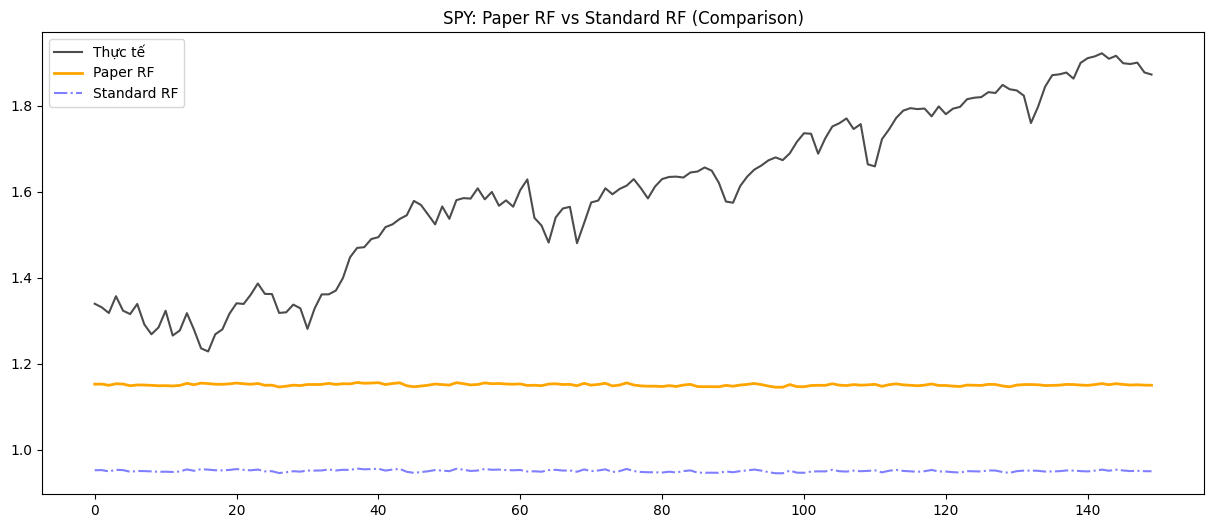

In [3]:
# --- CODE MODEL 3: RANDOM FOREST (PAPER vs STANDARD) - MODULAR VERSION ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CẤU HÌNH RANDOM FOREST ---
RF_CONFIG = {
    'LOOK_BACK': 80,       # Cửa sổ trượt
    'N_ESTIMATORS': 100,   # Số lượng cây (B)
    'LAMBDA': -0.002,      # Hệ số phạt (Lambda)
    'N_JOBS': -1,          # Dùng full CPU
    'RANDOM_STATE': 42
}

# --- 2. CÁC CLASS VÀ HÀM HỖ TRỢ ---

class PaperRandomForest(RandomForestRegressor):
    """
    Random Forest tùy chỉnh theo phương trình (1) của bài báo.
    Công thức: Prediction = Standard_RF_Prediction - (lambda * B)
    """
    def __init__(self, n_estimators=100, penalty_lambda=0.0, **kwargs):
        super().__init__(n_estimators=n_estimators, **kwargs)
        self.penalty_lambda = penalty_lambda
        self.B = n_estimators 
        
    def predict(self, X):
        base_pred = super().predict(X)
        penalty = self.penalty_lambda * self.B
        return base_pred - penalty

def create_flattened_dataset(dataset_df, look_back=60):
    """Chuyển đổi Time Series (3D/Sequences) thành dạng phẳng (2D) cho RF"""
    data = dataset_df.values
    X, y = [], []
    target_idx = 0 
    
    for i in range(len(data) - look_back):
        window = data[i:(i + look_back), :]
        X.append(window.flatten())
        y.append(data[i + look_back, target_idx])
        
    return np.array(X), np.array(y)

# --- 3. HÀM THỰC THI CHÍNH (GENERIC & CONDITIONAL) ---
def run_rf_comparison(train_data, test_data, ticker_name="Unknown"):
    print(f"\n🌲 BẮT ĐẦU RANDOM FOREST CHO: {ticker_name}...")
    
    # 1. Chuẩn bị dữ liệu
    look_back = RF_CONFIG['LOOK_BACK']
    X_train, y_train = create_flattened_dataset(train_data, look_back)
    X_test, y_test = create_flattened_dataset(test_data, look_back)
    
    print(f"   Input Shape: {X_train.shape} (Samples, Features * Lookback)")

    # 2. Train Paper Random Forest (LUÔN LUÔN CHẠY)
    print(f"   👉 Training Paper RF (Lambda={RF_CONFIG['LAMBDA']})...")
    paper_rf = PaperRandomForest(
        n_estimators=RF_CONFIG['N_ESTIMATORS'],
        penalty_lambda=RF_CONFIG['LAMBDA'],
        n_jobs=RF_CONFIG['N_JOBS'],
        random_state=RF_CONFIG['RANDOM_STATE']
    )
    paper_rf.fit(X_train, y_train)
    y_pred_paper = paper_rf.predict(X_test)
    
    # Lưu kết quả quan trọng nhất vào biến toàn cục để dùng cho Ensemble sau này
    global rfr_predictions 
    rfr_predictions = y_pred_paper 
    
    # Hàm tính metric nội bộ
    def get_metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100
        return rmse, r2, dir_acc

    rmse_p, r2_p, da_p = get_metrics(y_test, y_pred_paper)

    # 3. Xử lý logic so sánh (Dựa trên biến cmp)
    if cmp == 1:
        # --- CHẾ ĐỘ SO SÁNH: CHẠY THÊM STANDARD RF ---
        print(f"   👉 Training Standard RF (Pure Sklearn) [Comparison Mode ON]...")
        std_rf = RandomForestRegressor(
            n_estimators=RF_CONFIG['N_ESTIMATORS'],
            n_jobs=RF_CONFIG['N_JOBS'],
            random_state=RF_CONFIG['RANDOM_STATE']
        )
        std_rf.fit(X_train, y_train)
        y_pred_std = std_rf.predict(X_test)
        
        rmse_s, r2_s, da_s = get_metrics(y_test, y_pred_std)
        
        # In bảng so sánh
        print("\n📊 --- BẢNG SO SÁNH HIỆU SUẤT ---")
        print(f"{'Metric':<10} | {'PAPER RF':<15} | {'STANDARD RF':<15}")
        print("-" * 45)
        print(f"{'RMSE':<10} | {rmse_p:.4f}{' '*9} | {rmse_s:.4f}")
        print(f"{'R2':<10} | {r2_p:.4f}{' '*9} | {r2_s:.4f}")
        print(f"{'Dir Acc':<10} | {da_p:.2f}%{' '*8} | {da_s:.2f}%")
        
        if rmse_p < rmse_s:
            print("\n✅ Paper RF tốt hơn (RMSE thấp hơn).")
        else:
            print("\n⚠️ Standard RF tốt hơn (Có thể Lambda chưa tối ưu).")
            
    else:
        # --- CHẾ ĐỘ NHANH: CHỈ IN KẾT QUẢ PAPER RF ---
        print("\n📊 --- KẾT QUẢ PAPER RF (Comparison Mode OFF) ---")
        print(f"   RMSE: {rmse_p:.4f}")
        print(f"   R2 Score: {r2_p:.4f}")
        print(f"   Directional Accuracy: {da_p:.2f}%")

    # 4. Vẽ biểu đồ
    plt.figure(figsize=(15, 6))
    limit = 150
    plt.plot(y_test[:limit], label='Thực tế', color='black', alpha=0.7)
    plt.plot(y_pred_paper[:limit], label='Paper RF', color='orange', linewidth=2)
    
    if cmp == 1:
        plt.plot(y_pred_std[:limit], label='Standard RF', color='blue', linestyle='-.', alpha=0.5)
        plt.title(f'{ticker_name}: Paper RF vs Standard RF (Comparison)')
    else:
        plt.title(f'{ticker_name}: Paper RF Prediction')
        
    plt.legend()
    plt.show()

# --- 4. EXECUTION (MODULAR) ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and train_df is not None:
    run_rf_comparison(train_df, test_df, target_stock)
else:
    print("❌ Lỗi: Không tìm thấy dữ liệu train_df/test_df. Vui lòng chạy Algorithm 1 trước.")

2025-12-15 05:29:18.348017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765776558.520458      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765776558.576489      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


🚀 BẮT ĐẦU ROLLING WINDOW LSTM CHO: SPY...
   Tổng mẫu: 3176 | Window: 1260 | Step: 20


Training Progress:   0%|          | 0/1916 [00:00<?, ?it/s]

I0000 00:00:1765776572.358010      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765776576.045577      92 cuda_dnn.cc:529] Loaded cuDNN version 90300



📊 --- KẾT QUẢ LSTM: SPY ---
   RMSE: 0.0445
   R2 Score: 0.9966
   Directional Accuracy: 65.95%


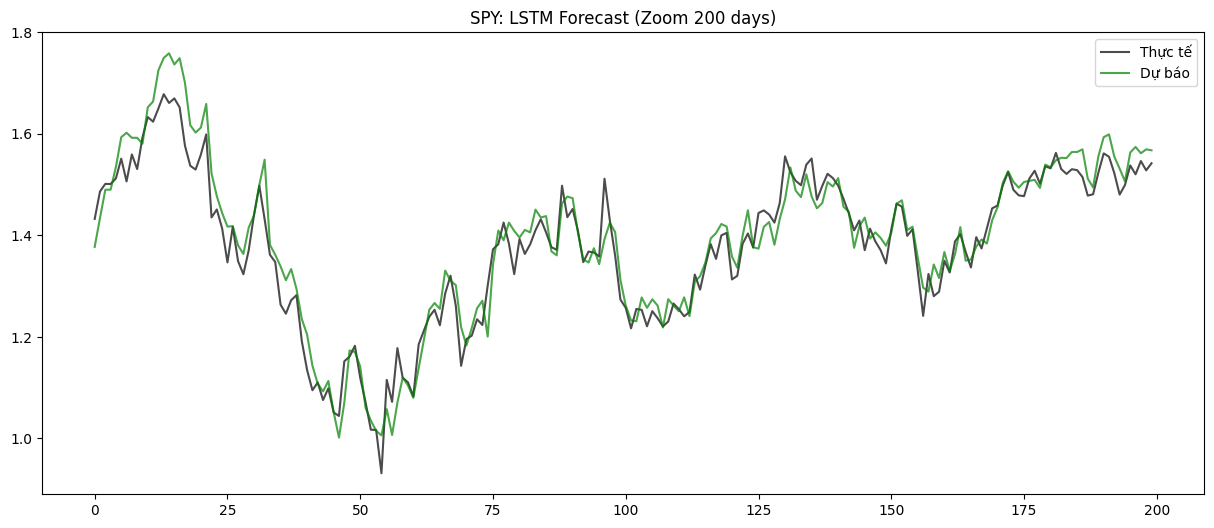

In [4]:
# --- CODE MODEL 2: LSTM ROLLING WINDOW (GENERIC & OPTIMIZED SPEED) ---
import os
import logging
import warnings

# 1. TỐI ƯU HÓA: Single GPU (Nhanh nhất cho loop liên tục)
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

# ======================================================
# CẤU HÌNH LSTM (GLOBAL CONFIG)
# ======================================================
LSTM_CONFIG = {
    'LOOK_BACK': 60,          # 60 ngày quá khứ
    'TRAIN_WINDOW': 252 * 5,  # 5 năm training
    'PREDICT_HORIZON': 20,    # Retrain sau mỗi 1 tháng
    'EPOCHS': 5,              # 5 epoch là đủ vì ta dùng Incremental Learning
    'BATCH_SIZE': 32,
    'UNITS': 50,              
    'DROPOUT': 0.2
}

# --- HÀM HỖ TRỢ ---
def create_dataset_3d(dataset, look_back=60):
    """Chuyển đổi dữ liệu sang 3D cho LSTM"""
    X, y = [], []
    target_idx = 0 
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, target_idx])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    """Xây dựng mạng LSTM"""
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=LSTM_CONFIG['UNITS'], return_sequences=True))
    model.add(Dropout(LSTM_CONFIG['DROPOUT']))
    model.add(LSTM(units=LSTM_CONFIG['UNITS'], return_sequences=False))
    model.add(Dropout(LSTM_CONFIG['DROPOUT']))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# --- HÀM THỰC THI (INCREMENTAL LEARNING) ---
def run_rolling_window_lstm(train_data, test_data, ticker_symbol="Unknown"):
    print(f"\n🚀 BẮT ĐẦU ROLLING WINDOW LSTM CHO: {ticker_symbol}...")
    
    # 1. Gộp dữ liệu train/test thành 1 dòng thời gian
    full_df = pd.concat([train_data, test_data])
    data_values = full_df.values
    
    # 2. Tạo dataset
    X_all, y_all = create_dataset_3d(data_values, LSTM_CONFIG['LOOK_BACK'])
    total_samples = len(X_all)
    
    train_window = LSTM_CONFIG['TRAIN_WINDOW']
    step_size = LSTM_CONFIG['PREDICT_HORIZON']
    start_index = train_window 
    
    all_preds = []
    all_actuals = []
    
    print(f"   Tổng mẫu: {total_samples} | Window: {train_window} | Step: {step_size}")
    pbar = tqdm(total=total_samples - start_index, desc="Training Progress")
    
    # --- TỐI ƯU HÓA TỐC ĐỘ ---
    tf.keras.backend.clear_session()
    
    # Khởi tạo model 1 lần duy nhất bên ngoài vòng lặp
    model = build_lstm_model((LSTM_CONFIG['LOOK_BACK'], X_all.shape[2]))
    
    current_idx = start_index
    
    while current_idx < total_samples:
        # A. Cắt dữ liệu
        train_start = current_idx - train_window
        train_end = current_idx
        X_train = X_all[train_start:train_end]
        y_train = y_all[train_start:train_end]
        
        test_end = min(current_idx + step_size, total_samples)
        X_test = X_all[current_idx:test_end]
        y_test = y_all[current_idx:test_end]
        
        if len(X_test) == 0: break
            
        # B. Retrain (Incremental - Học nối tiếp)
        # Model giữ lại kiến thức cũ, học thêm dữ liệu mới -> Rất nhanh & hiệu quả
        model.fit(X_train, y_train, 
                  epochs=LSTM_CONFIG['EPOCHS'], 
                  batch_size=LSTM_CONFIG['BATCH_SIZE'], 
                  verbose=0)
        
        # C. Predict
        preds = model.predict(X_test, verbose=0)
        all_preds.extend(preds.flatten())
        all_actuals.extend(y_test)
        
        # D. Update
        processed = len(y_test)
        current_idx += processed
        pbar.update(processed)
        
    pbar.close()
    return np.array(all_actuals), np.array(all_preds)

def evaluate_lstm_results(y_true, y_pred, ticker_symbol):
    print(f"\n📊 --- KẾT QUẢ LSTM: {ticker_symbol} ---")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    dir_acc = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100
    
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R2 Score: {r2:.4f}")
    print(f"   Directional Accuracy: {dir_acc:.2f}%")
    
    # Vẽ biểu đồ Zoom
    plt.figure(figsize=(15, 6))
    limit = 200
    if len(y_true) > limit:
        plt.plot(y_true[-limit:], label='Thực tế', color='black', alpha=0.7)
        plt.plot(y_pred[-limit:], label='Dự báo', color='green', alpha=0.7)
        plt.title(f'{ticker_symbol}: LSTM Forecast (Zoom {limit} days)')
    else:
        plt.plot(y_true, label='Thực tế')
        plt.plot(y_pred, label='Dự báo')
    plt.legend()
    plt.show()

# --- EXECUTION (GENERIC) ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and train_df is not None:
    y_true_roll, y_pred_roll = run_rolling_window_lstm(train_df, test_df, target_stock)
    evaluate_lstm_results(y_true_roll, y_pred_roll, target_stock)
    
    # Lưu biến kết quả dùng chung
    lstm_predictions = y_pred_roll
else:
    print("❌ Lỗi: Không tìm thấy dữ liệu. Hãy chạy Algorithm 1 trước.")


🛑 [CMP=1] ĐANG CHẠY STANDARD LSTM (STATIC MODE) CHO: SPY...
   Training Static Model (20 Epochs)...
   Predicting on Test set...

METRIC          | STANDARD (STATIC)      | PAPER (ADAPTIVE)      
----------------------------------------------------------------------
RMSE            | 0.1737                | 0.0672 ✅
MAE             | 0.1460                | 0.0516 ✅
Dir Acc         | 63.71%               | 68.31% ✅
💡 KẾT LUẬN: Cơ chế Adaptive (Paper) HIỆU QUẢ HƠN Static!


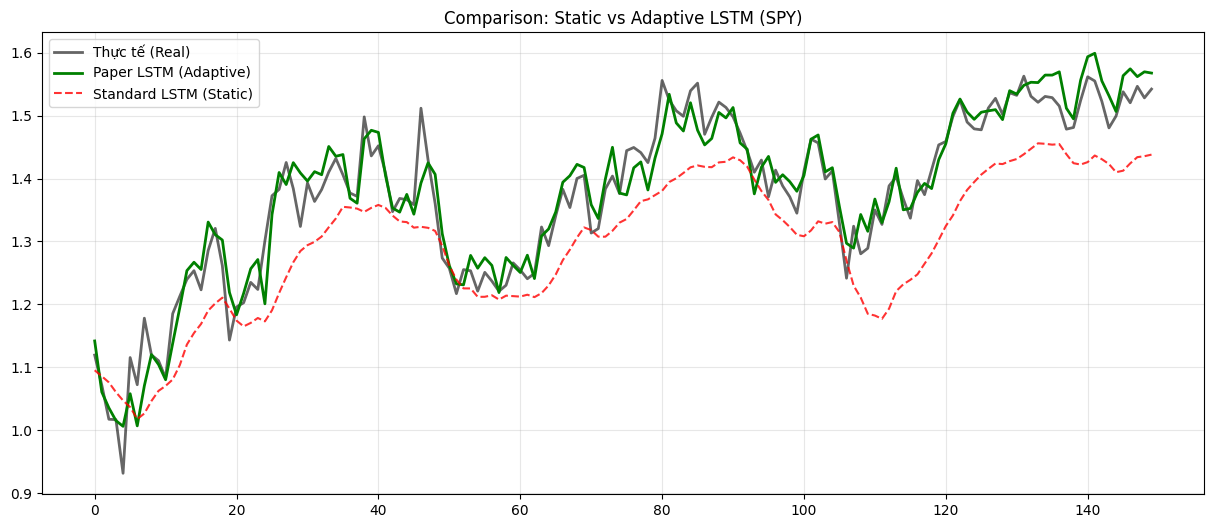

In [5]:
# --- CODE COMPARISON: STATIC LSTM vs ADAPTIVE LSTM (MODULAR & CONDITIONAL) ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def run_static_lstm_comparison(train_data, test_data, adaptive_preds, ticker_symbol="Unknown"):
    """
    So sánh hiệu quả giữa Static Model và Adaptive Model.
    Nếu cmp=0: Chỉ đánh giá Adaptive Model (Bỏ qua Static để tiết kiệm thời gian).
    """
    
    # 1. Chuẩn bị dữ liệu Ground Truth (Thực tế) từ tập Test
    # Ta luôn cần cái này để chấm điểm, dù có chạy Static hay không
    look_back = LSTM_CONFIG['LOOK_BACK']
    
    # Chỉ cần tạo X_test, y_test để lấy Ground Truth
    # (X_test chỉ dùng nếu chạy Static, y_test dùng để so khớp)
    X_test_std, y_test_std = create_dataset_3d(test_data.values, look_back)
    
    # 2. ĐỒNG BỘ HÓA DỮ LIỆU (ALIGNMENT) CHO ADAPTIVE MODEL
    # Cắt lấy đoạn giao nhau cuối cùng giữa Thực tế và Dự báo Rolling
    min_len = min(len(y_test_std), len(adaptive_preds))
    
    y_true_final = y_test_std[-min_len:]       # Thực tế
    y_pred_adap_final = adaptive_preds[-min_len:] # Adaptive Prediction
    
    # Hàm tính metrics nội bộ
    def get_metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        dir_acc = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100
        return rmse, mae, dir_acc

    # Tính điểm cho Adaptive Model (Luôn chạy)
    rmse_a, mae_a, acc_a = get_metrics(y_true_final, y_pred_adap_final)

    # 3. XỬ LÝ LOGIC SO SÁNH (DỰA TRÊN BIẾN cmp)
    if cmp == 1:
        print(f"\n🛑 [CMP=1] ĐANG CHẠY STANDARD LSTM (STATIC MODE) CHO: {ticker_symbol}...")
        
        # A. Chuẩn bị dữ liệu Train cho Static
        X_train_std, y_train_std = create_dataset_3d(train_data.values, look_back)
        
        # B. Xây dựng và Train Model
        tf.keras.backend.clear_session()
        model_std = build_lstm_model((X_train_std.shape[1], X_train_std.shape[2]))
        
        print("   Training Static Model (20 Epochs)...")
        model_std.fit(X_train_std, y_train_std, 
                      epochs=20, 
                      batch_size=LSTM_CONFIG['BATCH_SIZE'], 
                      verbose=0)
        
        # C. Dự báo
        print("   Predicting on Test set...")
        y_pred_static = model_std.predict(X_test_std, verbose=0).flatten()
        
        # D. Cắt dữ liệu Static cho khớp độ dài
        y_pred_stat_final = y_pred_static[-min_len:]
        
        # E. Tính điểm Static
        rmse_s, mae_s, acc_s = get_metrics(y_true_final, y_pred_stat_final)
        
        # F. IN BẢNG SO SÁNH
        print(f"\n{'='*70}")
        print(f"{'METRIC':<15} | {'STANDARD (STATIC)':<22} | {'PAPER (ADAPTIVE)':<22}")
        print(f"{'-'*70}")
        
        def mark(val1, val2, higher_better=False):
            better = (val1 > val2) if higher_better else (val1 < val2)
            return '✅' if better else ''

        print(f"{'RMSE':<15} | {rmse_s:.4f} {mark(rmse_s, rmse_a)}{' '*14} | {rmse_a:.4f} {mark(rmse_a, rmse_s)}")
        print(f"{'MAE':<15} | {mae_s:.4f} {mark(mae_s, mae_a)}{' '*14} | {mae_a:.4f} {mark(mae_a, mae_s)}")
        print(f"{'Dir Acc':<15} | {acc_s:.2f}% {mark(acc_s, acc_a, True)}{' '*13} | {acc_a:.2f}% {mark(acc_a, acc_s, True)}")
        print(f"{'='*70}")
        
        if rmse_a < rmse_s:
            print("💡 KẾT LUẬN: Cơ chế Adaptive (Paper) HIỆU QUẢ HƠN Static!")
        else:
            print("💡 KẾT LUẬN: Static đang tốt hơn (Cần xem lại tham số Rolling).")
            
    else:
        # --- CHẾ ĐỘ NHANH (CMP=0) ---
        print(f"\n🚀 [CMP=0] KẾT QUẢ ADAPTIVE LSTM (ROLLING) CHO: {ticker_symbol}")
        print(f"   (Đã bỏ qua Static Model để tiết kiệm thời gian)")
        print(f"{'-'*40}")
        print(f"   RMSE: {rmse_a:.4f}")
        print(f"   MAE: {mae_a:.4f}")
        print(f"   Directional Accuracy: {acc_a:.2f}%")

    # 4. VẼ BIỂU ĐỒ
    plt.figure(figsize=(15, 6))
    zoom = 150 # Zoom 150 ngày cuối
    
    # Luôn vẽ Thực tế và Adaptive
    plt.plot(y_true_final[-zoom:], label='Thực tế (Real)', color='black', linewidth=2, alpha=0.6)
    plt.plot(y_pred_adap_final[-zoom:], label='Paper LSTM (Adaptive)', color='green', linewidth=2)
    
    # Chỉ vẽ Static nếu có chạy so sánh
    if cmp == 1:
        plt.plot(y_pred_stat_final[-zoom:], label='Standard LSTM (Static)', color='red', linestyle='--', alpha=0.8)
        plt.title(f'Comparison: Static vs Adaptive LSTM ({ticker_symbol})')
    else:
        plt.title(f'Performance: Adaptive LSTM Rolling Window ({ticker_symbol})')
        
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- EXECUTION (MODULAR) ---
# Yêu cầu: Biến lstm_predictions (từ Cell 2) phải tồn tại
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and 'lstm_predictions' in globals():
    run_static_lstm_comparison(train_df, test_df, lstm_predictions, target_stock)
else:
    print("⚠️ Lỗi: Thiếu dữ liệu. Hãy chạy Algorithm 1 và LSTM Rolling trước.")


📉 ĐANG HUẤN LUYỆN LINEAR REGRESSION CHO: SPY...
   Input Shape: (2528, 600)

📊 --- KẾT QUẢ LINEAR REGRESSION ---
   RMSE: 0.0376
   R2 Score: 0.9806
   Directional Accuracy: 65.42%


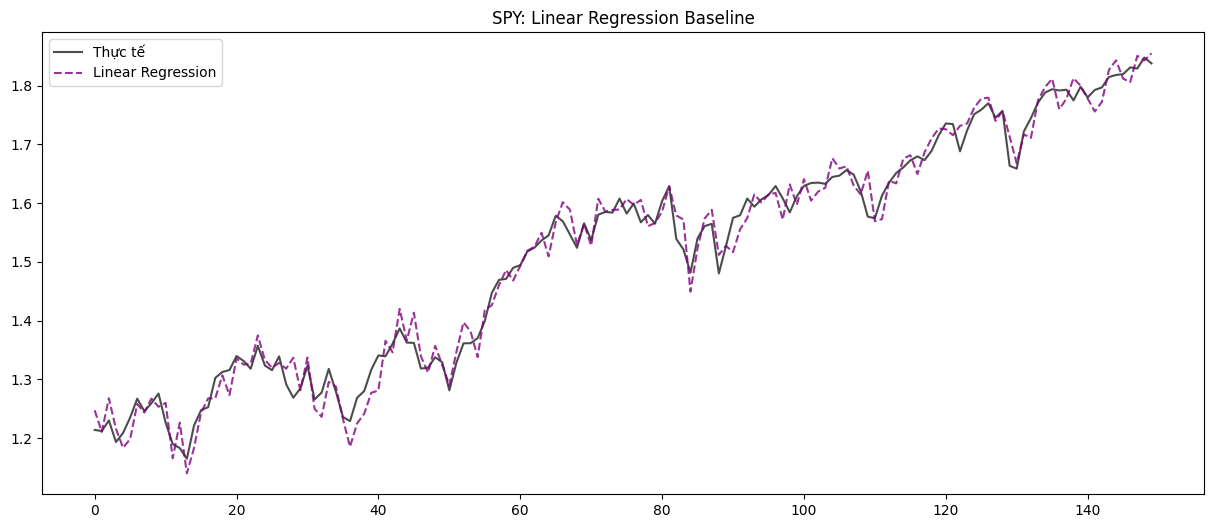

In [6]:
# --- CODE MODEL 4: LINEAR REGRESSION (BASELINE) - MODULAR ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# ======================================================
# CẤU HÌNH (Dùng chung Lookback với các model khác)
# ======================================================
LR_CONFIG = {
    'LOOK_BACK': 60
}

# --- HÀM HỖ TRỢ (Tự định nghĩa lại để Cell này chạy độc lập) ---
def create_flattened_dataset_lr(dataset_df, look_back=60):
    """Chuyển đổi dữ liệu sang dạng phẳng (2D) cho LR"""
    data = dataset_df.values
    X, y = [], []
    target_idx = 0 
    for i in range(len(data) - look_back):
        window = data[i:(i + look_back), :]
        X.append(window.flatten())
        y.append(data[i + look_back, target_idx])
    return np.array(X), np.array(y)

# --- HÀM THỰC THI CHÍNH ---
def run_linear_regression(train_data, test_data, ticker_symbol="Unknown"):
    print(f"\n📉 ĐANG HUẤN LUYỆN LINEAR REGRESSION CHO: {ticker_symbol}...")
    
    # 1. Chuẩn bị dữ liệu
    look_back = LR_CONFIG['LOOK_BACK']
    X_train, y_train = create_flattened_dataset_lr(train_data, look_back)
    X_test, y_test = create_flattened_dataset_lr(test_data, look_back)
    
    print(f"   Input Shape: {X_train.shape}")
    
    # 2. Khởi tạo và Train
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # 3. Dự báo
    y_pred = lr_model.predict(X_test)
    
    # 4. Đánh giá
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    dir_acc = np.mean(np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred))) * 100
    
    print(f"\n📊 --- KẾT QUẢ LINEAR REGRESSION ---")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R2 Score: {r2:.4f}")
    print(f"   Directional Accuracy: {dir_acc:.2f}%")
    
    # 5. Vẽ biểu đồ
    plt.figure(figsize=(15, 6))
    limit = 150
    plt.plot(y_test[:limit], label='Thực tế', color='black', alpha=0.7)
    plt.plot(y_pred[:limit], label='Linear Regression', color='purple', linestyle='--', alpha=0.8)
    plt.title(f'{ticker_symbol}: Linear Regression Baseline')
    plt.legend()
    plt.show()
    
    return y_pred

# --- EXECUTION (MODULAR) ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and train_df is not None:
    # Chạy model
    lr_predictions = run_linear_regression(train_df, test_df, target_stock)
else:
    print("❌ Lỗi: Không tìm thấy dữ liệu train_df/test_df.")


🐢 ĐANG HUẤN LUYỆN SVR (Support Vector Regression) CHO: SPY...
   Input Shape: (2528, 600)

📊 --- KẾT QUẢ SVR (Tuned) ---
   RMSE: 0.0613
   R2 Score: 0.9482
   Directional Accuracy: 62.35%


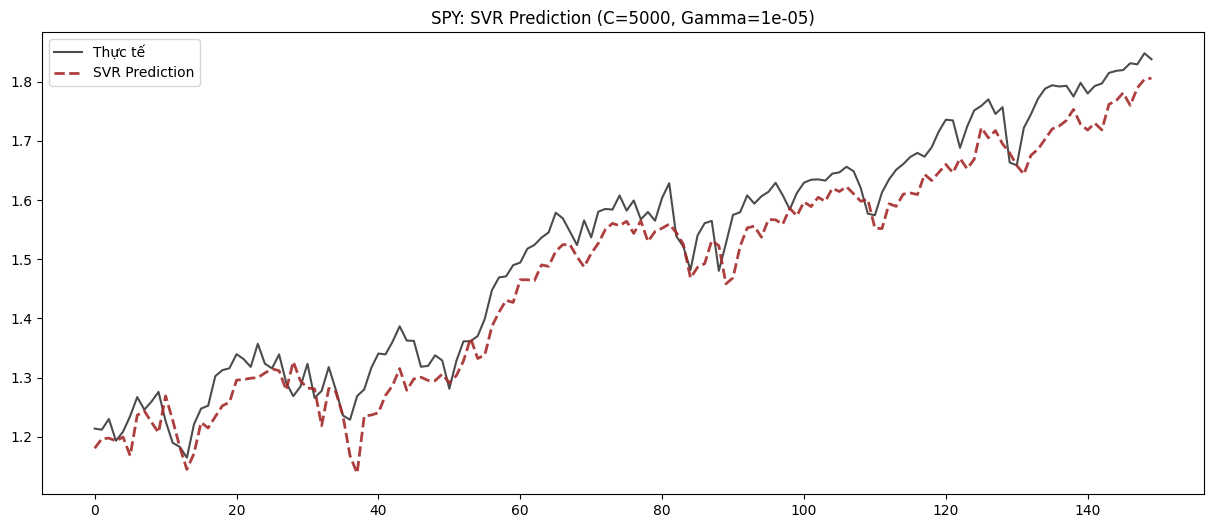

In [7]:
# --- CODE MODEL 4: SUPPORT VECTOR REGRESSION (SVR) - MODULAR ---
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# ======================================================
# CẤU HÌNH SVR (Sử dụng tham số tối ưu đã tìm được)
# ======================================================
SVR_CONFIG = {
    'LOOK_BACK': 60,
    'KERNEL': 'rbf',
    'C': 5000,          # Phạt nặng sai số để giảm trễ (Lag)
    'GAMMA': 1e-05,   # Gamma siêu nhỏ để làm mượt dữ liệu nhiều chiều
    'EPSILON': 0.05
}

# --- HÀM HỖ TRỢ ---
def create_flattened_dataset_svr(dataset_df, look_back=60):
    """Chuyển đổi dữ liệu sang dạng phẳng (2D) cho SVR"""
    data = dataset_df.values
    X, y = [], []
    target_idx = 0 
    for i in range(len(data) - look_back):
        window = data[i:(i + look_back), :]
        X.append(window.flatten())
        y.append(data[i + look_back, target_idx])
    return np.array(X), np.array(y)

# --- HÀM THỰC THI CHÍNH ---
def run_svr_model(train_data, test_data, ticker_symbol="Unknown"):
    print(f"\n🐢 ĐANG HUẤN LUYỆN SVR (Support Vector Regression) CHO: {ticker_symbol}...")
    
    # 1. Chuẩn bị dữ liệu
    look_back = SVR_CONFIG['LOOK_BACK']
    X_train, y_train = create_flattened_dataset_svr(train_data, look_back)
    X_test, y_test = create_flattened_dataset_svr(test_data, look_back)
    
    print(f"   Input Shape: {X_train.shape}")
    
    # 2. Khởi tạo SVR với tham số tối ưu
    svr_model = SVR(
        kernel=SVR_CONFIG['KERNEL'], 
        C=SVR_CONFIG['C'], 
        gamma=SVR_CONFIG['GAMMA'],
        epsilon=SVR_CONFIG['EPSILON']
    )
    
    # 3. Training (Có thể mất chút thời gian nếu dữ liệu lớn)
    # Nếu máy quá yếu, có thể giới hạn dữ liệu train: X_train[-2000:]
    svr_model.fit(X_train, y_train)
    
    # 4. Dự báo
    y_pred = svr_model.predict(X_test)
    
    # 5. Đánh giá
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    dir_acc = np.mean(np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred))) * 100
    
    print(f"\n📊 --- KẾT QUẢ SVR (Tuned) ---")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R2 Score: {r2:.4f}")
    print(f"   Directional Accuracy: {dir_acc:.2f}%")
    
    # 6. Vẽ biểu đồ
    plt.figure(figsize=(15, 6))
    limit = 150
    plt.plot(y_test[:limit], label='Thực tế', color='black', alpha=0.7)
    plt.plot(y_pred[:limit], label='SVR Prediction', color='brown', linestyle='--', alpha=0.9, linewidth=2)
    plt.title(f'{ticker_symbol}: SVR Prediction (C={SVR_CONFIG["C"]}, Gamma={SVR_CONFIG["GAMMA"]})')
    plt.legend()
    plt.show()
    
    return y_pred

# --- EXECUTION (MODULAR) ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and train_df is not None:
    # Chạy model và lưu kết quả vào biến toàn cục generic
    svr_predictions = run_svr_model(train_df, test_df, target_stock)
else:
    print("❌ Lỗi: Không tìm thấy dữ liệu train_df/test_df.")


📦 ĐANG TẬP HỢP DỮ LIỆU TỪ CÁC MODEL LẺ...
   Tìm thấy 4 models: ['LSTM', 'SVR', 'RF', 'LR']
   ✂️ Cắt đồng bộ dữ liệu: Lấy 568 mẫu cuối cùng.
✅ Đã chuẩn bị xong dữ liệu Ensemble!

🧠 BẮT ĐẦU DYNAMIC ENSEMBLE (RL - UCB) CHO: SPY...
   ⏳ Agent đang học Online qua 568 ngày dữ liệu...

🏆 --- KẾT QUẢ DYNAMIC ENSEMBLE (FINAL) ---
Metric               | Value     
-----------------------------------
RMSE                 | 0.1143
MAE                  | 0.0969
R2 Score             | 0.7560
Directional Acc      | 49.21%


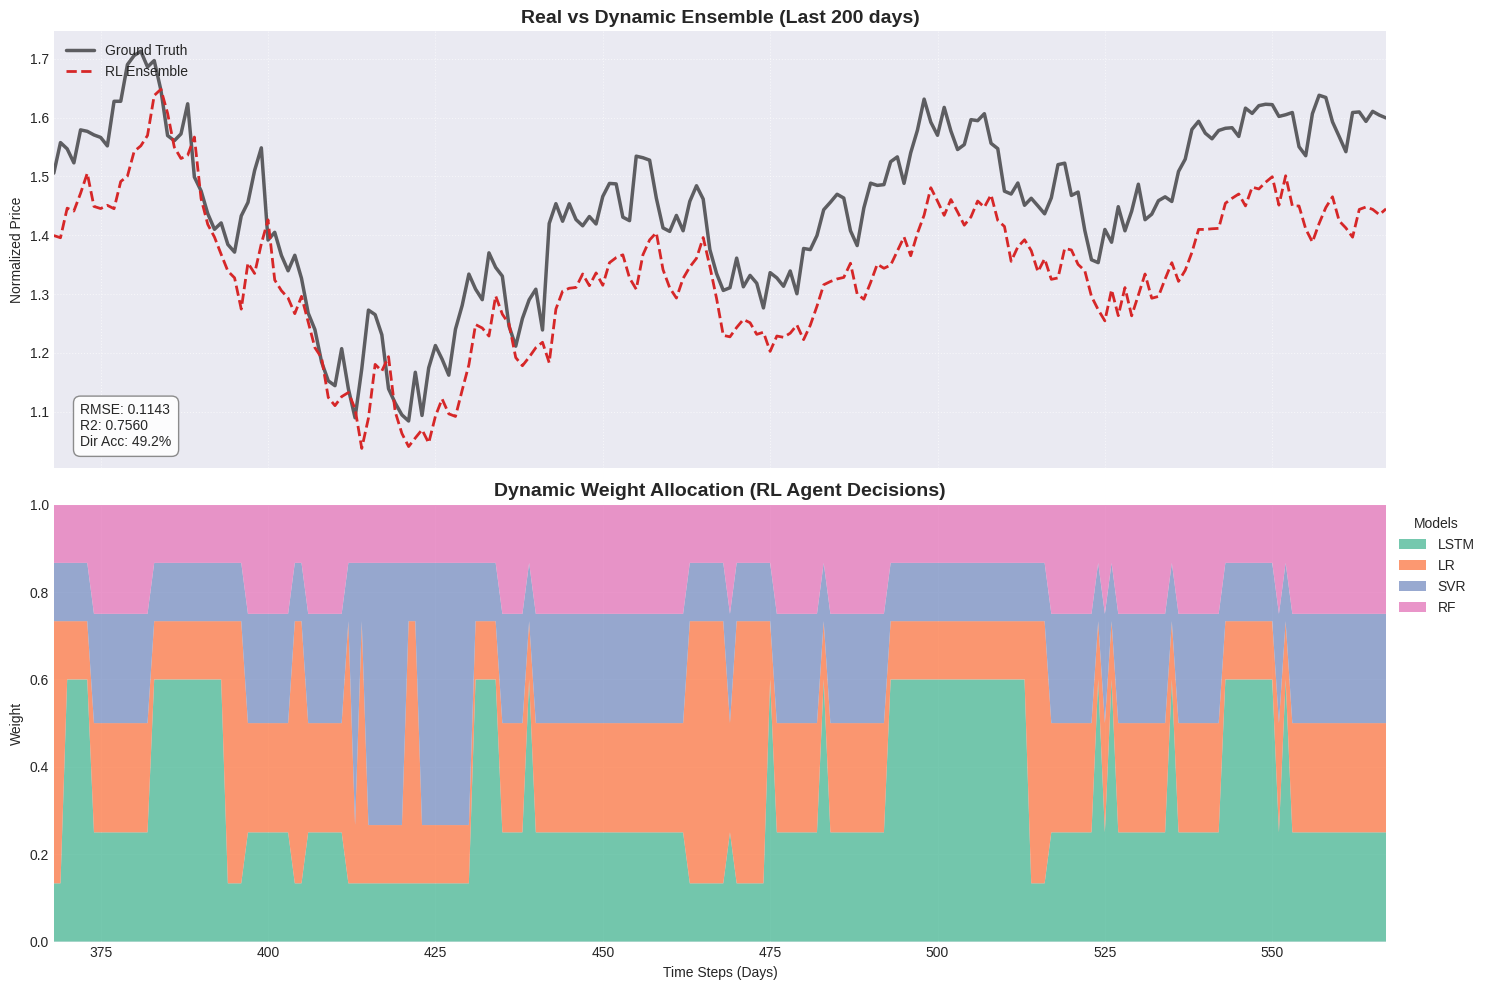

✅ Đã cập nhật dynamic_predictions.


In [8]:
# --- CODE ALGORITHM 3.2: DYNAMIC WEIGHT (RL - UCB) - FIXED CHART & LOGIC ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ======================================================
# CẤU HÌNH RL AGENT (ĐIỀU CHỈNH ĐỂ BOT NHẠY HƠN)
# ======================================================
RL_CONFIG = {
    'LEARNING_RATE': 0.1,      # Học chậm mà chắc, tránh Overreaction
    'DISCOUNT_FACTOR': 0.8,    # Quan tâm cả ngắn hạn và dài hạn
    'EXPLORATION_CONST': 2.0,  # Khuyến khích thử nghiệm mạnh mẽ
    'WINDOW_SIZE': 5,          # Phản ứng nhanh với thay đổi tuần (5 ngày giao dịch)
    'P_TRUST': 0.6,
    'ACTIONS': ['TRUST_LSTM', 'TRUST_SVR', 'TRUST_RF', 'TRUST_LR', 'BALANCED']
}

class QLearningEnsembleAgent:
    def __init__(self, models_list):
        self.models = models_list 
        self.n_models = len(models_list)
        # Random nhẹ Q-table ban đầu để phá vỡ thế cân bằng
        self.q_table = np.random.uniform(0, 0.1, (self.n_models, len(RL_CONFIG['ACTIONS'])))
        self.total_steps = 0
        self.action_counts = np.zeros(len(RL_CONFIG['ACTIONS']))
        
    def get_state(self, recent_errors):
        # State = Index của Model tốt nhất
        best_model_name = min(recent_errors, key=recent_errors.get)
        return self.models.index(best_model_name)

    def take_action(self, state_idx):
        # Chọn Action có Q-value cao nhất
        action_idx = np.argmax(self.q_table[state_idx])
        return action_idx

    def update_weights_by_action(self, action_idx):
        self.total_steps += 1
        self.action_counts[action_idx] += 1
        
        # Logic phân bổ trọng số: 
        p_trust = RL_CONFIG['P_TRUST']
        weights = np.ones(self.n_models) * ((1 - p_trust) / (self.n_models - 1))
        if action_idx < self.n_models: 
            weights[action_idx] = p_trust
        else: # Balanced
            weights = np.ones(self.n_models) / self.n_models
        return weights
    
    def calculate_augmented_reward(self, y_true, y_pred, action_idx):
        # 1. Accuracy Reward
        error = (y_true - y_pred) ** 2
        # Tăng độ nhạy: Error nhỏ xíu cũng tạo ra Reward lớn
        accuracy = 1.0 / (error + 1e-5) 
        
        # 2. Exploration Reward (UCB)
        N = self.total_steps
        ni = self.action_counts[action_idx] + 1 # +1 tránh chia 0
        epsilon = RL_CONFIG['EXPLORATION_CONST']
        
        exploration = epsilon * np.sqrt(np.log(N+1) / ni)
            
        return accuracy + exploration

    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        
        # Công thức Bellman
        new_value = old_value + RL_CONFIG['LEARNING_RATE'] * (
            reward + RL_CONFIG['DISCOUNT_FACTOR'] * next_max - old_value
        )
        self.q_table[state, action] = new_value

# --- HÀM THỰC THI & VẼ BIỂU ĐỒ SỬA LỖI ---
def run_dynamic_ensemble_rl(test_data, model_preds_dict, ticker_symbol="Unknown"):
    print(f"\n🧠 BẮT ĐẦU DYNAMIC ENSEMBLE (RL - UCB) CHO: {ticker_symbol}...")
    
    # 1. Đồng bộ dữ liệu
    y_true_full = test_data['Adj Close_Norm'].values
    min_len = len(y_true_full)
    available_models = list(model_preds_dict.keys())
    
    for name in available_models:
        min_len = min(min_len, len(model_preds_dict[name]))
        
    y_true = y_true_full[-min_len:]
    aligned_preds = {k: v[-min_len:] for k, v in model_preds_dict.items()}
    
    agent = QLearningEnsembleAgent(available_models)
    
    dynamic_predictions = []
    weight_history = []
    window = RL_CONFIG['WINDOW_SIZE']
    
    print(f"   ⏳ Agent đang học Online qua {min_len} ngày dữ liệu...")
    
    # --- TRAINING LOOP ---
    for t in range(min_len):
        current_preds = np.array([aligned_preds[m][t] for m in available_models])
        
        if t < window:
            weights = np.ones(len(available_models)) / len(available_models)
            final_pred = np.dot(weights, current_preds)
            dynamic_predictions.append(final_pred)
            weight_history.append(weights)
            agent.total_steps += 1
            continue
            
        # Get State
        recent_errors = {}
        for idx, m in enumerate(available_models):
            past_pred = aligned_preds[m][t-window:t]
            past_true = y_true[t-window:t]
            recent_errors[m] = mean_squared_error(past_true, past_pred)
            
        state = agent.get_state(recent_errors)
        
        # Take Action
        action = agent.take_action(state)
        weights = agent.update_weights_by_action(action)
        
        # Predict
        final_pred = np.dot(weights, current_preds)
        dynamic_predictions.append(final_pred)
        weight_history.append(weights)
        
        # Reward & Update
        reward = agent.calculate_augmented_reward(y_true[t], final_pred, action)
        agent.update_q_table(state, action, reward, state)
        
    dynamic_predictions = np.array(dynamic_predictions)
    weight_history = np.array(weight_history)
    
    # --- 2. TÍNH TOÁN FULL METRICS ---
    rmse = np.sqrt(mean_squared_error(y_true, dynamic_predictions))
    mae = mean_absolute_error(y_true, dynamic_predictions)
    r2 = r2_score(y_true, dynamic_predictions)
    dir_acc = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(dynamic_predictions))) * 100
    
    print(f"\n🏆 --- KẾT QUẢ DYNAMIC ENSEMBLE (FINAL) ---")
    print(f"{'Metric':<20} | {'Value':<10}")
    print("-" * 35)
    print(f"{'RMSE':<20} | {rmse:.4f}")
    print(f"{'MAE':<20} | {mae:.4f}")
    print(f"{'R2 Score':<20} | {r2:.4f}")
    print(f"{'Directional Acc':<20} | {dir_acc:.2f}%")
    
    # --- 3. VẼ BIỂU ĐỒ (ĐÃ FIX LỖI TRỤC X) ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
    
    # Xác định vùng Zoom (200 ngày cuối)
    zoom_len = min(200, min_len)
    
    # [QUAN TRỌNG] Tạo trục X cụ thể để vẽ đúng vị trí
    time_steps = np.arange(min_len - zoom_len, min_len)
    
    # CHART 1: Real vs Pred
    ax1.plot(time_steps, y_true[-zoom_len:], label='Ground Truth', color='black', linewidth=2.5, alpha=0.6)
    ax1.plot(time_steps, dynamic_predictions[-zoom_len:], label='RL Ensemble', color='#d62728', linewidth=2, linestyle='--')
    
    ax1.set_title(f'Real vs Dynamic Ensemble (Last {zoom_len} days)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Normalized Price')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':', alpha=0.6)
    
    # Text Box
    stats_text = f'RMSE: {rmse:.4f}\nR2: {r2:.4f}\nDir Acc: {dir_acc:.1f}%'
    ax1.text(0.02, 0.05, stats_text, transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=0.5'), fontsize=10)

    # CHART 2: Weights
    # Lấy dữ liệu weights của đoạn zoom tương ứng
    zoom_weights = weight_history[-zoom_len:].T
    
    colors = sns.color_palette("Set2", len(available_models)) 
    ax2.stackplot(time_steps, zoom_weights, labels=available_models, colors=colors, alpha=0.9)
    
    ax2.set_title(f'Dynamic Weight Allocation (RL Agent Decisions)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time Steps (Days)')
    ax2.set_ylabel('Weight')
    ax2.set_xlim(time_steps[0], time_steps[-1]) # Set giới hạn nhìn chuẩn xác
    ax2.set_ylim(0, 1.0)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")
    
    plt.tight_layout()
    plt.show()
    
    return dynamic_predictions

def prepare_ensemble_data(test_df):
    print("\n📦 ĐANG TẬP HỢP DỮ LIỆU TỪ CÁC MODEL LẺ...")
    
    # 1. Thu thập các biến toàn cục
    # Tự động tìm kiếm các biến kết quả từ các bước trước
    raw_preds = {}
    if 'lstm_predictions' in globals(): raw_preds['LSTM'] = lstm_predictions
    if 'svr_predictions' in globals(): raw_preds['SVR'] = svr_predictions
    if 'rfr_predictions' in globals(): raw_preds['RF'] = rfr_predictions
    if 'lr_predictions' in globals(): raw_preds['LR'] = lr_predictions
    
    if len(raw_preds) == 0:
        print("❌ LỖI: Chưa có model nào được chạy (LSTM, SVR, RF...).")
        return None, None
    
    print(f"   Tìm thấy {len(raw_preds)} models: {list(raw_preds.keys())}")

    # 2. Đồng bộ độ dài (Alignment)
    # Lấy độ dài ngắn nhất (do mỗi model có thể mất số lượng mẫu đầu khác nhau vì Lookback)
    # Và so với cả độ dài thực tế của Test Set
    
    y_true_full = test_df['Adj Close_Norm'].values
    min_len = len(y_true_full)
    
    for name, pred in raw_preds.items():
        min_len = min(min_len, len(pred))
        
    print(f"   ✂️ Cắt đồng bộ dữ liệu: Lấy {min_len} mẫu cuối cùng.")

    # 3. Cắt dữ liệu
    # Dữ liệu thực tế (Ground Truth)
    y_true_aligned = y_true_full[-min_len:]
    
    # Dữ liệu dự báo (Predictions Dictionary)
    aligned_preds_dict = {k: v[-min_len:] for k, v in raw_preds.items()}
    
    print("✅ Đã chuẩn bị xong dữ liệu Ensemble!")
    return y_true_aligned, aligned_preds_dict

# --- EXECUTION ---
# Biến toàn cục CHUẨN để dùng cho cả Static Ensemble và RL Dynamic
if 'test_df' in globals():
    y_true_ensemble, all_preds_dict = prepare_ensemble_data(test_df)
else:
    print("❌ Lỗi: Thiếu test_df (Chưa chạy Algorithm 1).")

# --- EXECUTION ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'all_preds_dict' in globals() and 'test_df' in globals():
    # Chọn input: LSTM, SVR, RF, LR
    rl_input_preds = {k: all_preds_dict[k] for k in ['LSTM', 'LR', 'SVR', 'RF'] if k in all_preds_dict}
    
    if len(rl_input_preds) > 0:
        dynamic_predictions = run_dynamic_ensemble_rl(test_df, rl_input_preds, target_stock)
        print("✅ Đã cập nhật dynamic_predictions.")
    else:
        print("❌ Không đủ model đầu vào.")
else:
    print("❌ Thiếu dữ liệu (Cần chạy Cell 4.5 trước).")


🔗 BẮT ĐẦU STATIC ENSEMBLE (BENCHMARK) CHO: SPY
Model      | RMSE       | R2        
-----------------------------------
LSTM       | 0.0779     | 0.8867
SVR        | 0.0747     | 0.8957
LR         | 0.0698     | 0.9090
RF         | 0.4898     | -3.4810

⚖️ PHÂN BỔ TRỌNG SỐ (STATIC):
   LSTM: 0.3014 (30.1%)
   SVR: 0.3142 (31.4%)
   LR: 0.3364 (33.6%)
   RF: 0.0479 (4.8%)

🏆 --- KẾT QUẢ STATIC ENSEMBLE ---
   RMSE: 0.0703 | Dir Acc: 49.74%

⚔️ --- CUỘC CHIẾN: STATIC (1/RMSE) vs. DYNAMIC (RL) ---
Metric          | STATIC          | DYNAMIC (RL)    | Winner
-----------------------------------------------------------------
RMSE            | 0.0703          | 0.1143          | Static
Dir Acc         | 49.74%         | 49.21%         | Static


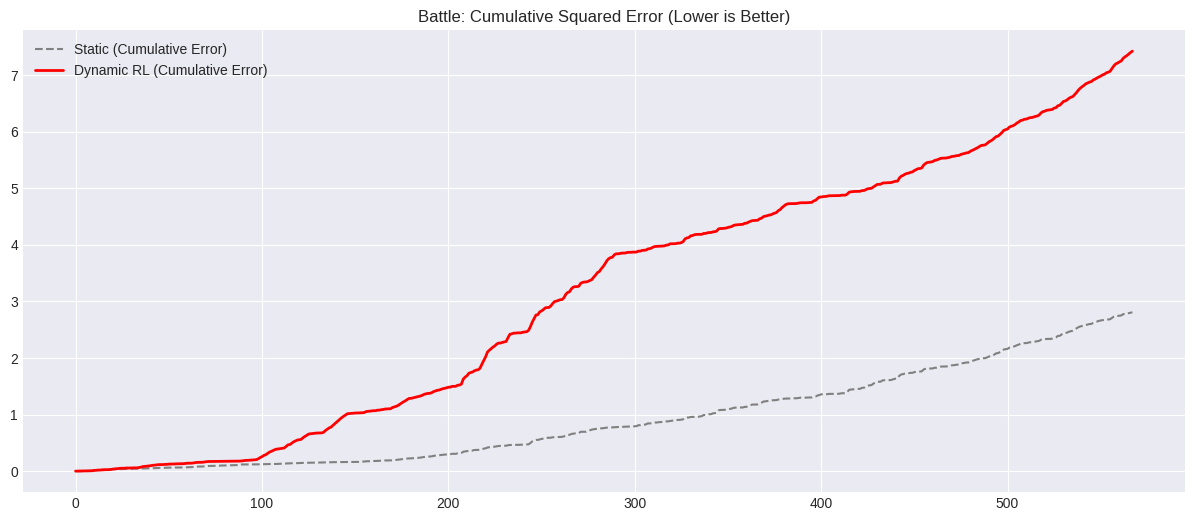


✅ [CMP=1] So sánh hoàn tất. Sử dụng kết quả DYNAMIC (RL) cho các bước sau.


In [9]:
# --- CODE MODEL 5: ENSEMBLE (WEIGHTED AVERAGE) - MODULAR & SELECTIVE ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ======================================================
# CẤU HÌNH ENSEMBLE
# ======================================================
ENSEMBLE_CONFIG = {
    'METHOD': 'inverse_rmse',  # 'inverse_rmse' hoặc 'average'
    'TARGET_COL': 'Adj Close_Norm'
}

# --- 1. HÀM ENSEMBLE CHÍNH (STATIC) ---
def run_modular_ensemble(test_data, model_preds_dict, selected_models=None, ticker_symbol="Unknown"):
    # Lọc model
    available_models = list(model_preds_dict.keys())
    if selected_models is None:
        final_selection = available_models
    else:
        final_selection = [m for m in selected_models if m in model_preds_dict]
    
    if not final_selection:
        print("❌ Lỗi: Không có model hợp lệ.")
        return None, None
    
    # Đồng bộ dữ liệu
    y_true_full = test_data[ENSEMBLE_CONFIG['TARGET_COL']].values
    min_len = len(y_true_full)
    for name in final_selection:
        min_len = min(min_len, len(model_preds_dict[name]))
    
    y_true = y_true_full[-min_len:]
    aligned_preds = {k: model_preds_dict[k][-min_len:] for k in final_selection}
    
    # Tính toán Metric & Trọng số
    scores = {}
    valid_models_final = []
    
    print(f"\n🔗 BẮT ĐẦU STATIC ENSEMBLE (BENCHMARK) CHO: {ticker_symbol}")
    print(f"{'Model':<10} | {'RMSE':<10} | {'R2':<10}")
    print("-" * 35)
    
    for name, pred in aligned_preds.items():
        rmse = np.sqrt(mean_squared_error(y_true, pred))
        r2 = r2_score(y_true, pred)
        scores[name] = {'rmse': rmse, 'r2': r2}
        print(f"{name:<10} | {rmse:.4f}     | {r2:.4f}")
        valid_models_final.append(name)

    # Tính Weights
    weights = {}
    if ENSEMBLE_CONFIG['METHOD'] == 'inverse_rmse':
        inv_rmse_sum = 0
        temp_weights = {}
        for name in valid_models_final:
            w = 1 / (scores[name]['rmse'] + 1e-6)
            temp_weights[name] = w
            inv_rmse_sum += w
        for name in valid_models_final:
            weights[name] = temp_weights[name] / inv_rmse_sum if inv_rmse_sum > 0 else 0
    else: 
        w = 1.0 / len(valid_models_final)
        for name in valid_models_final: weights[name] = w

    print("\n⚖️ PHÂN BỔ TRỌNG SỐ (STATIC):")
    for name, w in weights.items():
        print(f"   {name}: {w:.4f} ({w*100:.1f}%)")

    # Cộng gộp
    final_pred = np.zeros_like(y_true)
    for name in valid_models_final:
        final_pred += aligned_preds[name] * weights[name]
        
    # Đánh giá
    rmse_ens = np.sqrt(mean_squared_error(y_true, final_pred))
    dir_acc = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(final_pred))) * 100
    
    print(f"\n🏆 --- KẾT QUẢ STATIC ENSEMBLE ---")
    print(f"   RMSE: {rmse_ens:.4f} | Dir Acc: {dir_acc:.2f}%")
    
    return final_pred, weights

# --- 2. HÀM SO SÁNH (HEAD-TO-HEAD) ---
def compare_static_vs_dynamic(test_data, static_preds, dynamic_preds):
    print("\n⚔️ --- CUỘC CHIẾN: STATIC (1/RMSE) vs. DYNAMIC (RL) ---")
    
    y_true = test_data[ENSEMBLE_CONFIG['TARGET_COL']].values
    min_len = min(len(y_true), len(static_preds), len(dynamic_preds))
    y_true = y_true[-min_len:]
    static = static_preds[-min_len:]
    dynamic = dynamic_preds[-min_len:]
    
    rmse_s = np.sqrt(mean_squared_error(y_true, static))
    rmse_d = np.sqrt(mean_squared_error(y_true, dynamic))
    acc_s = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(static))) * 100
    acc_d = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(dynamic))) * 100
    
    print(f"{'Metric':<15} | {'STATIC':<15} | {'DYNAMIC (RL)':<15} | {'Winner'}")
    print("-" * 65)
    print(f"{'RMSE':<15} | {rmse_s:.4f}{' '*9} | {rmse_d:.4f}{' '*9} | {'Static' if rmse_s < rmse_d else 'Dynamic'}")
    print(f"{'Dir Acc':<15} | {acc_s:.2f}%{' '*8} | {acc_d:.2f}%{' '*8} | {'Static' if acc_s > acc_d else 'Dynamic'}")

    plt.figure(figsize=(15, 6))
    plt.plot(np.cumsum((y_true - static)**2), label='Static (Cumulative Error)', color='gray', linestyle='--')
    plt.plot(np.cumsum((y_true - dynamic)**2), label='Dynamic RL (Cumulative Error)', color='red', linewidth=2)
    plt.title('Battle: Cumulative Squared Error (Lower is Better)')
    plt.legend()
    plt.show()

# --- EXECUTION (STRICT CONDITIONAL) ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'test_df' in globals():
    # 1. Thu thập input
    all_preds_dict = {}
    if 'lstm_predictions' in globals(): all_preds_dict['LSTM'] = lstm_predictions
    if 'svr_predictions' in globals(): all_preds_dict['SVR'] = svr_predictions
    if 'rfr_predictions' in globals(): all_preds_dict['RF'] = rfr_predictions
    if 'lr_predictions' in globals(): all_preds_dict['LR'] = lr_predictions
    
    my_selection = ['LSTM', 'SVR', 'LR', 'RF'] 

    # 2. KIỂM TRA CMP
    if cmp == 1:
        # CHỈ CHẠY KHI CMP = 1
        if len(all_preds_dict) > 0:
            # A. Chạy Static
            static_predictions, _ = run_modular_ensemble(test_df, all_preds_dict, my_selection, target_stock)
            
            # B. So sánh với RL (nếu có)
            if 'dynamic_predictions' in globals():
                compare_static_vs_dynamic(test_df, static_predictions, dynamic_predictions)
                # Khi cmp=1, ta ưu tiên dùng kết quả RL để đi tiếp (vì nó xịn hơn)
                ensemble_predictions = dynamic_predictions
                print("\n✅ [CMP=1] So sánh hoàn tất. Sử dụng kết quả DYNAMIC (RL) cho các bước sau.")
            else:
                print("\n⚠️ [CMP=1] Không thấy kết quả RL. Đang dùng tạm Static.")
                ensemble_predictions = static_predictions
        else:
             print("❌ Lỗi: Không có model input.")
             
    else:
        # KHI CMP = 0 -> KHÔNG LÀM GÌ CẢ (SKIP STATIC)
        # Chỉ đảm bảo biến ensemble_predictions tồn tại từ bước RL trước đó
        if 'dynamic_predictions' in globals():
            ensemble_predictions = dynamic_predictions
            print(f"\n🚀 [CMP=0] Đã bỏ qua Static Ensemble. Sử dụng kết quả DYNAMIC (RL) có sẵn.")
        else:
            print(f"\n⚠️ [CMP=0] Cảnh báo: Bạn chưa chạy RL (Cell 3.2), cũng không chạy Static.")
            print("   -> Các bước sau (Monte Carlo) có thể bị lỗi thiếu biến 'ensemble_predictions'.")

else:
    print("❌ Lỗi: Thiếu dữ liệu test_df.")